<h1>台積電擴大赴美投資情緒分析2</h1>

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [55]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [2]:
# 確認當前工作目錄
# %pwd

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import opencc

In [2]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [3]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=0dc9f919-b0c6-4e44-aa71-2fcc770e7e35
To: /Users/yolun/SMA_2025S/studyGroup/data.zip
100%|██████████| 1.88G/1.88G [04:47<00:00, 6.54MB/s]


### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [4]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2025-03-18 15:40:31.144482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future 

## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
<h3>資料簡介</h3>
<ul>
<li>資料來源:PTT-stock版文章</li>
<li>爬取工具:tarflow工具</li>
<li>關鍵字:台積電,美積電,亞利桑那</li>
<li>取用期間:2024/10/01~2025/3/12</li>  
<li>文章筆數:2,546</li>
</ul>

In [19]:
## 讀取文章
df = pd.read_csv('./raw_data/program1.csv')
# 確保 artDate 欄位為字串，避免雜訊
df["artDate"] = df["artDate"].astype(str).str.strip()
# 嘗試轉換日期，錯誤的值變成 NaT
df["artDate"] = pd.to_datetime(df["artDate"], errors="coerce")
# 檢查無效日期
#print("無效日期數量:", df["artDate"].isna().sum())
# 查看無效日期的前 20 筆
#invalid_dates = df[df["artDate"].isna()]
#print(invalid_dates[["artDate"]].head(20))
# 選擇是否要刪除無效日期
df = df.dropna(subset=["artDate"])
print("artDate 已成功轉換，合併後的 DataFrame：")
df["artDate"] = df["artDate"].dt.date
df.head(3)

artDate 已成功轉換，合併後的 DataFrame：


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,Lefty,Stock,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kkes0001"", ""...",180.177.26.33,2024/9/2 2:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,derrengay,Stock,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xxgogg"", ""cm...",112.78.86.207,2024/9/2 2:03,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,cjol,Stock,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""st9061204"", ...",122.117.2.178,2024/9/2 2:03,ptt


定義文字清理的相關function

In [29]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

import re

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ 
    Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 確保 article 為字串，避免浮點數導致錯誤
    2. 去除(\\n)
    3. 去除特殊符號字元
    4. 保留數字 (選擇性)
    5. 保留字母 (選擇性)
    6. 依照斷句字元進行斷句，全形的分號、逗號、句號、問號以及驚嘆號
    7. 避免空白斷句結果

    Args:
        article (str): 欲斷行之文章內容
        keep_digits (bool): 決定是否保留數字於斷行後的結果
        keep_alphabets (bool): 決定是否保留字母於斷行後的結果
    Returns:
        list: 每個 element 就是一行
    """
    # 確保 article 為字串，避免 float 產生錯誤
    article = str(article) if article is not None else ""

    # 定義特殊符號與斷句標點
    special_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")

    # 過濾掉空白段落（確保非空白）
    paragraphs = list(filter(lambda x: re.sub(r'\s+', '', x), article.split("\n")))

    result = []
    for paragraph in paragraphs:
        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+', '', clean_paragraph)  # 移除數字
            if not keep_alphabets:
                clean_paragraph = re.sub(r'[a-zA-Z]+', '', clean_paragraph)  # 移除英文字母

            clean_paragraph = re.sub(r'[\s]+', '', clean_paragraph)  # 移除多餘空白
            clean_paragraph = re.sub(special_symbols, '', clean_paragraph)  # 移除特殊符號
            
        except Exception as e:
            return f"error: {e}"

        # 執行斷句
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)

    return result


CKIP 處理相關function

In [30]:
# 自定義辭典
with open('./raw_data/dict/user_dict2.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'拌飯': 500.0, '嚼勁': 500.0}), (3, {'重口味': 500.0, '炸物區': 500.0, '雞腿排': 500.0, '鴛鴦鍋': 500.0, '醬料區': 500.0, '新馬辣': 500.0, '肉次方': 500.0, '雪花牛': 500.0, '梅花豬': 500.0, '自助區': 500.0, '新北市': 500.0, '壽喜燒': 500.0, '握壽司': 500.0, '火鍋料': 500.0, '鮭魚卵': 500.0, '土瓶蒸': 500.0, '信義店': 500.0, '文山店': 500.0, '大安店': 500.0, '忠孝店': 500.0}), (4, {'饗食天堂': 500.0, '漢來海港': 500.0, '肋眼牛排': 500.0, '石頭火鍋': 500.0, '平日晚餐': 500.0, '韓式炸雞': 500.0, '梅花豬肉': 500.0, '日本料理': 500.0, '玉米濃湯': 500.0, '生菜沙拉': 500.0, '天使紅蝦': 500.0, '麻辣鴨血': 500.0, '火烤兩吃': 500.0, '剝皮辣椒': 500.0, '一蘭拉麵': 500.0})]


In [31]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [32]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['標的'], ['台積電'], ['分類多'], ['分析/正文'], ['今年第三季靠近尾端了,打些第四季或明年展望的部分']]
['標的', '台積電', '分類多', '分析/正文', '今年第三季靠近尾端了,打些第四季或明年展望的部分']


In [33]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 583.9208750724792


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [34]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,標的,Na
1,1,台積電,Nb
2,1,分類,Na
3,1,多,VH
4,1,分析,VC


In [35]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,台積電,ORG
1,1,今年第三季,DATE
2,1,第四,ORDINAL
3,1,明年,DATE
4,1,第三,ORDINAL


In [36]:
sentence_table.head()

,system_id,sentence
0,1,標的
1,1,台積電
2,1,分類多
3,1,分析/正文
4,1,"今年第三季靠近尾端了,打些第四季或明年展望的部分"


In [37]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 2541
posts have NER: 2533


In [40]:
# 將文章存成csv
pos_table.to_csv('./raw_data/zh/pos_table_buffet.csv', index = False)
entity_table.to_csv('./raw_data/zh/entity_table_buffet.csv', index = False)
sentence_table.to_csv('./raw_data/zh/sentence_table_buffet.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [41]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_buffet.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_buffet.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [42]:
entity_table['ner'].unique()

array(['ORG', 'DATE', 'ORDINAL', 'PERSON', 'NORP', 'LOC', 'TIME', 'GPE',
       'CARDINAL', 'MONEY', 'PRODUCT', 'WORK_OF_ART', 'EVENT', 'QUANTITY',
       'FAC', 'LANGUAGE', 'PERCENT', 'LAW'], dtype=object)

In [43]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
11,ORG,32085
4,GPE,15135
13,PERSON,11433
1,DATE,7730
0,CARDINAL,3345
8,MONEY,2241
9,NORP,1989
10,ORDINAL,1105
7,LOC,875
16,TIME,463


Text(0.5, 0, 'Frequency')

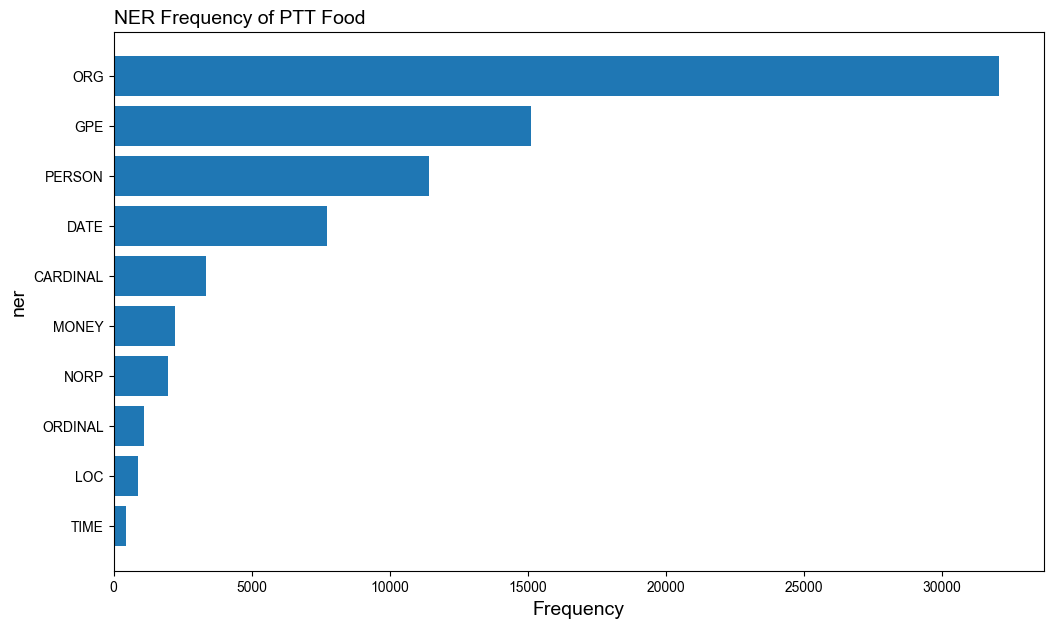

In [44]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

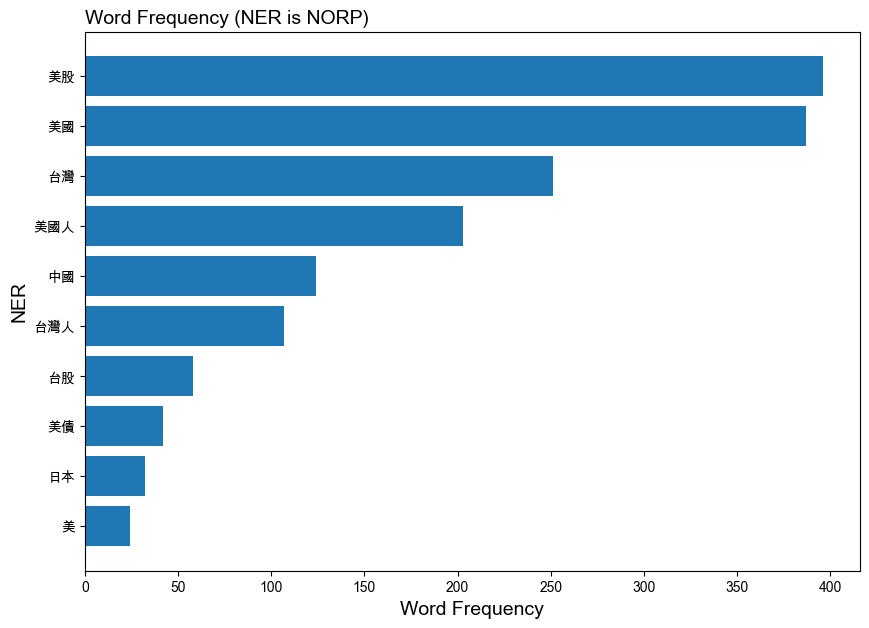

In [45]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到台灣人喜好的口味大多以「日式」、「韓式」料理為大宗

### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

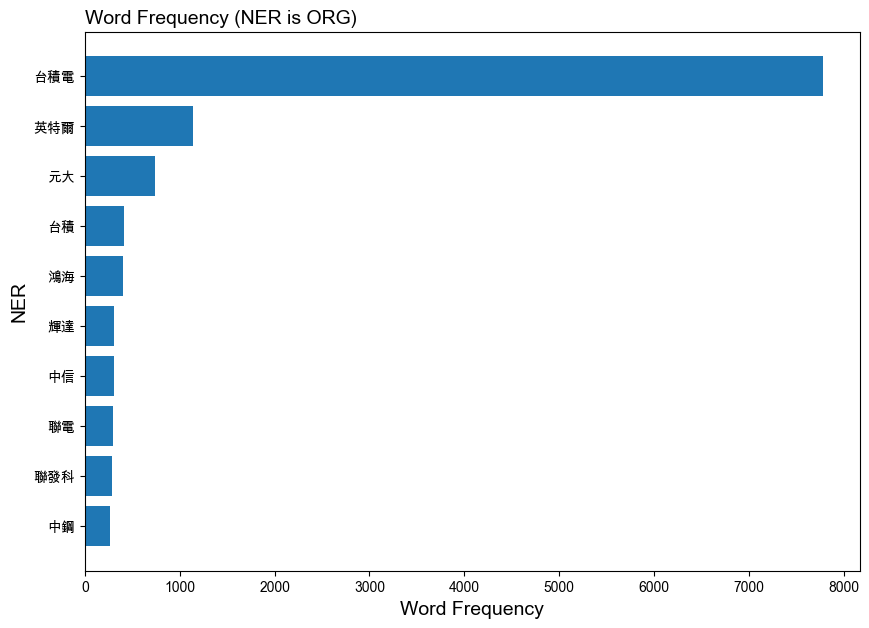

In [46]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到在多數的吃到飽食記之中，「哈根達斯」是多數食記會介紹到的一環，也間接反映出讀者對於吃到飽餐廳冰淇淋品牌的關注。

### 涉及到的人名(PERSON)

Text(0.5, 0, 'Word Frequency')

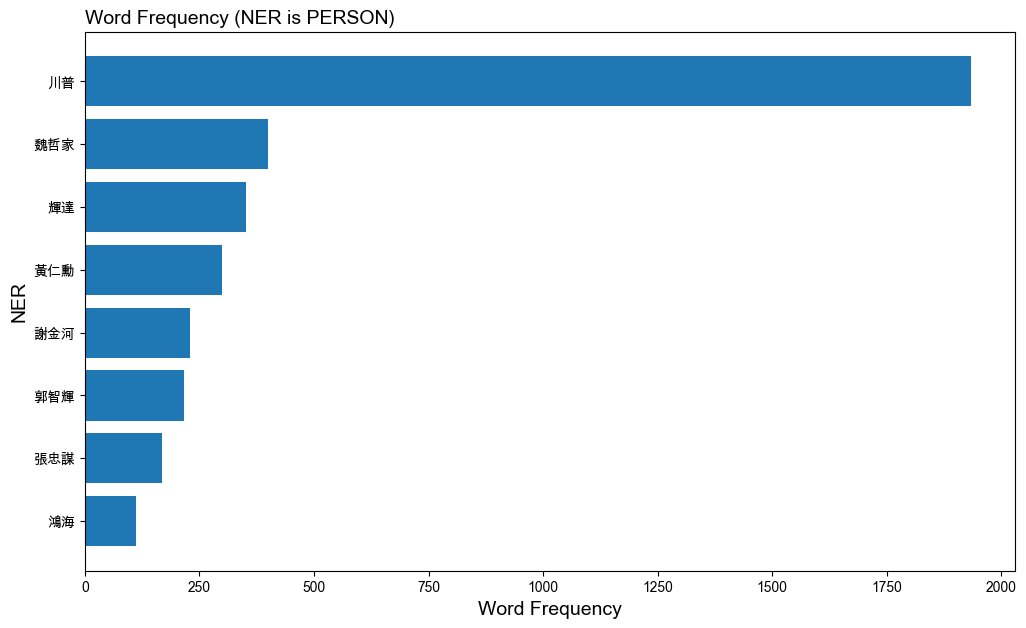

In [47]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

下面找出「台積電」相關文章，與後續情緒分析一起做探索

In [49]:
keyword_list = ['台積電']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [28]:
pos_table['pos'].unique()

array(['Nc', 'Na', 'Nb', 'FW', 'COMMACATEGORY', 'D', 'VD', 'VL', 'VC',
       'A', 'VF', 'VA', 'Nes', 'VH', 'VJ', 'Nep', 'Nf', 'P', 'Ncd', 'DE',
       'SHI', 'V_2', 'Neqa', 'Di', 'VG', 'Cbb', 'VK', 'Nh', 'Da', 'Caa',
       'VCL', 'Nd', 'Cab', 'Dfa', 'VHC', 'VE', 'Ng', 'Neu', 'VB', 'T',
       'VAC', 'Cba', 'Dk', 'VI', 'Dfb', 'Neqb', 'I', 'Nv',
       'PARENTHESISCATEGORY', 'DM', 'PERIODCATEGORY', 'COLONCATEGORY',
       'ETCCATEGORY', 'DASHCATEGORY', 'PAUSECATEGORY',
       'EXCLAMATIONCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [29]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
18,Na,284923
5,D,124221
45,VH,91747
39,VC,88049
7,DE,58008
20,Nc,47171
10,Dfa,33034
28,Nf,31076
32,P,24943
4,Cbb,24550


#### POS 常見詞性列表
+ Na: 普通名詞
+ D: 副詞
+ VC: 動作及物動詞
+ Nb: 專有名詞
+ FW: 外文
+ VH: 狀態不及物動詞
+ Nh: 代名詞
+ DE: 的之得地
+ P: 介詞
+ VA: 動作不及物動詞
+ T: 語助詞
+ SHI: 是

/var/folders/mg/v37yyv9s3tz8n2_t71gs0g2m0000gn/T/ipykernel_84011/2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


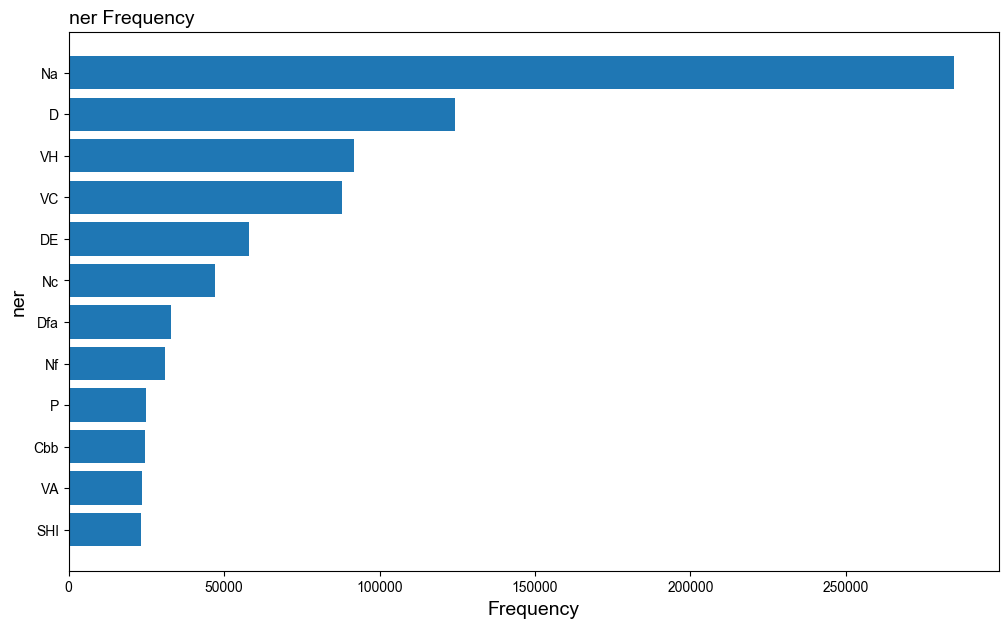

In [30]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論吃到飽時大部分討論到的名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [31]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
445,哈根達斯,284
637,安格斯,220
1968,菲力,170
1162,松阪,141
1260,欣葉,129
1058,旭集,107
1558,王品,101
2606,黑牛,87
1135,杜,85
1941,莫凡彼,82


/var/folders/mg/v37yyv9s3tz8n2_t71gs0g2m0000gn/T/ipykernel_84011/488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


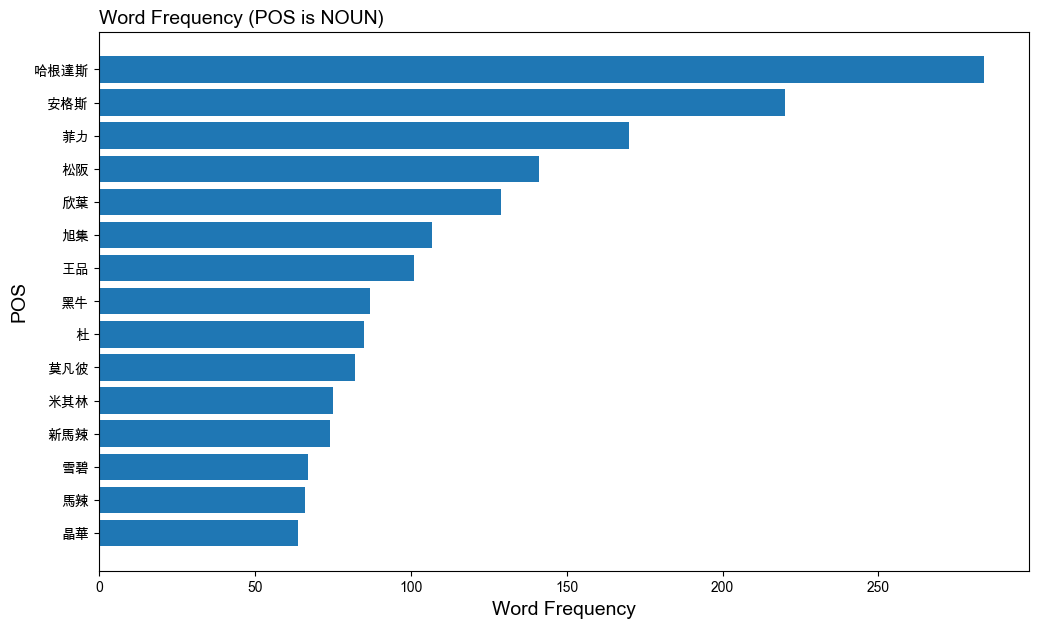

In [32]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到哈根達斯依舊是出現最多次的專有名詞，另外，從「安格斯」、「菲力」和「松阪」等專有名詞可以推測出大家對於肉類也有較高的討論度。

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [33]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
575,吃到,3954
3603,選擇,1738
1613,推薦,1632
1700,搭配,1632
2016,服務,1150
150,使用,652
585,吃完,595
104,享用,529
70,主打,357
541,參考,351


/var/folders/mg/v37yyv9s3tz8n2_t71gs0g2m0000gn/T/ipykernel_84011/29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


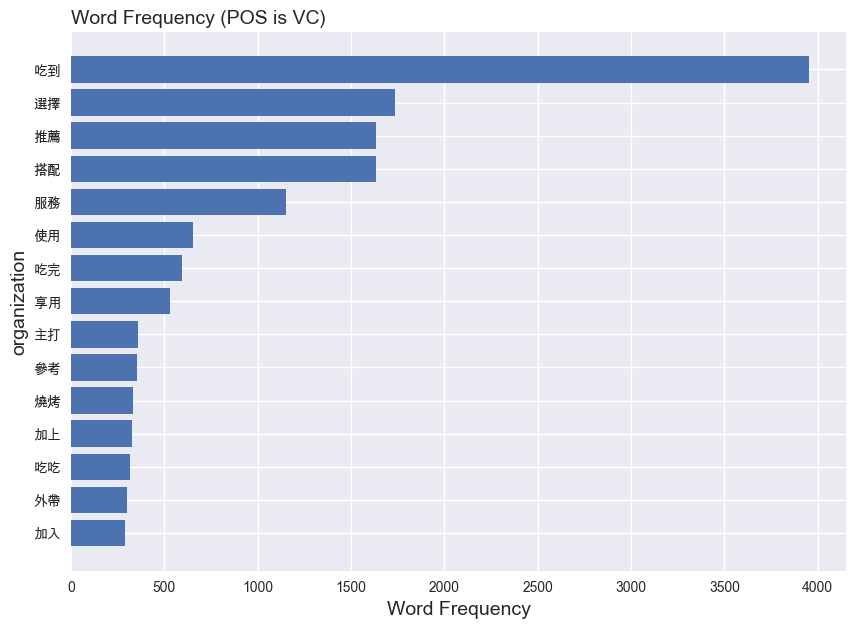

In [56]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「吃到」佔了相當高的頻率，其他還有出現「選擇」、「搭配」等詞彙，可推測民眾對於食材的選擇多樣性有較高的重視程度。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [35]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

使用先前NER得到的「旭集」相關文章，看看旭集相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [36]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
1024,14,餐廳名稱旭集和食集錦,2020-01-11 07:52:14,ptt
1025,14,消費時間年/月,2020-01-11 07:52:14,ptt
1026,14,例年月，未提供則文章不予保留，多訪綜合心得也請標上起迄時間,2020-01-11 07:52:14,ptt


In [37]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
1024,14,餐廳名稱旭集和食集錦,2020-01-11 07:52:14,ptt,0.957801
1025,14,消費時間年/月,2020-01-11 07:52:14,ptt,0.022688
1026,14,例年月，未提供則文章不予保留，多訪綜合心得也請標上起迄時間,2020-01-11 07:52:14,ptt,0.001094


In [38]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    4525.000000
mean        0.459747
std         0.333742
min         0.000005
25%         0.144210
50%         0.446491
75%         0.770438
max         1.000000
Name: sentimentValue, dtype: float64

<Axes: >

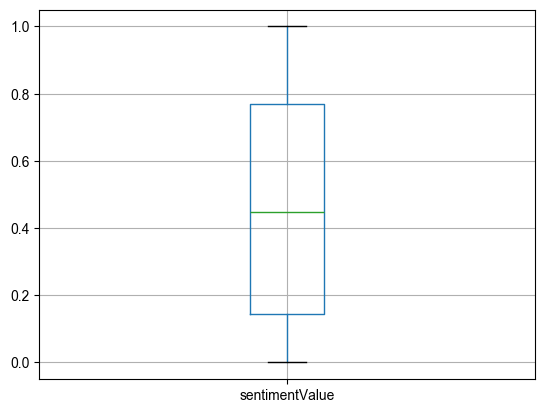

In [39]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [40]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2020-01,0.436593
1,2020-02,0.502081
2,2020-04,0.421835
3,2020-06,0.494982
4,2020-08,0.520563
5,2020-09,0.466738
6,2020-11,0.483612
7,2021-01,0.449730
8,2021-02,0.446720
9,2021-03,0.424271


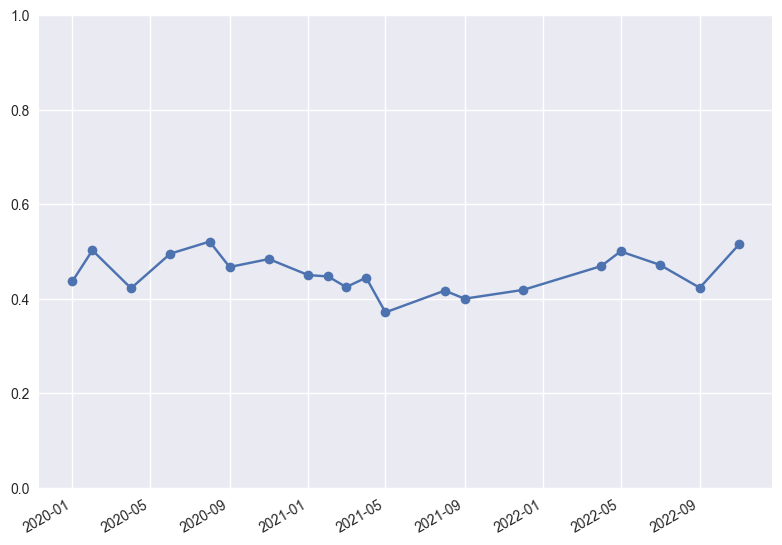

In [41]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性，推測是因為PTT美食板上多數為食記類型的介紹文章。我們挑出 2022年11月 來分析。

### 詞彙探索
從上圖中可以發現 2022年11月 的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [42]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2022-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
120172,1581,餐廳名稱旭集和食集錦義享店,2022-11,ptt,0.948446
120174,1581,地址高雄市鼓山區大順路號樓義享天地館,2022-11,ptt,0.714181
120179,1581,下午茶,2022-11,ptt,0.767852
120185,1581,饗食天堂旗下的頂級日本料理吃到飽旭集和食集錦目前共三間分店，台北高雄與竹北,2022-11,ptt,0.964028
120186,1581,高雄旭集位在義享天地，雖沒有台北旭集難訂,2022-11,ptt,0.996687


In [43]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,1581,0.948446,餐廳
1,1581,0.948446,名稱
2,1581,0.948446,旭集
3,1581,0.948446,和
4,1581,0.948446,食集


In [44]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [45]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種']


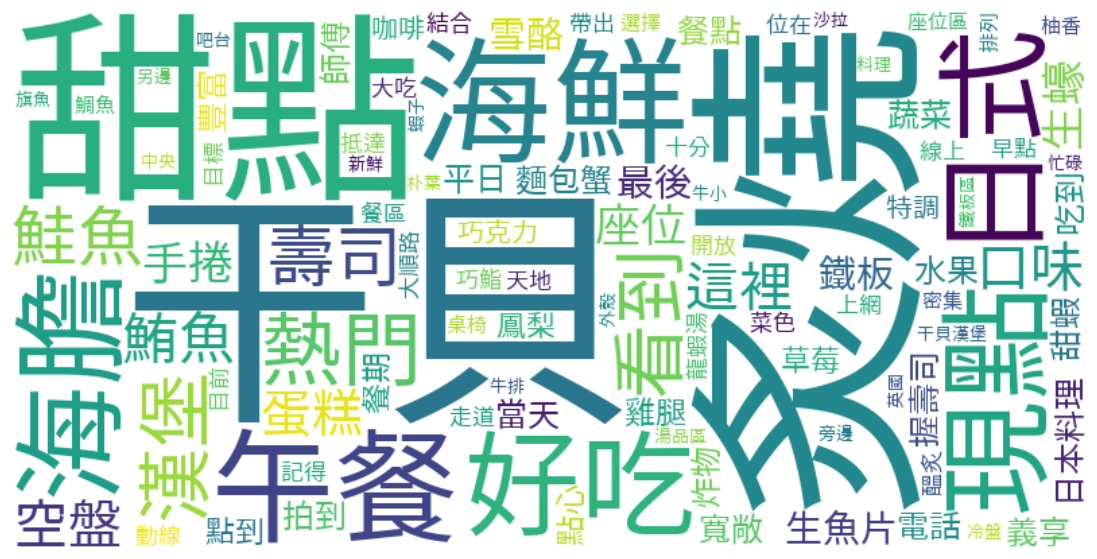

In [46]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','真的','台灣','台北','高雄','有點','完全','飯店','會館','旭集','訂位','最多','相當','不錯','部分','最多','提供'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

藉由各式海鮮以及「日式」、「手捲」、「壽司」等詞彙出現在正向文章中，可以知道多數文章對旭集的日本料理類有正面的評價，另外，甜點類也是多數文章會提及的詞彙